# Next Word Prediction:

### Importing The Required Libraries:

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import pickle
import numpy as np
import os

In [2]:
# Check if GPU is available
if tf.config.list_physical_devices('GPU'):
    print('GPU is available')
    device = '/GPU:0'
else:
    print('GPU is not available')
    device = '/CPU:0'

GPU is available


In [3]:
"""
    Dataset: http://www.gutenberg.org/cache/epub/5200/pg5200.txt
    Remove all the unnecessary data and label it as Metamorphosis-clean.
    The starting and ending lines should be as follows.

"""


file = open("metamorphosis_clean.txt", "r", encoding = "utf8")
lines = []

for i in file:
    lines.append(i)
    
print("The First Line: ", lines[0])
print("The Last Line: ", lines[-1])

The First Line:  ﻿One morning, when Gregor Samsa woke from troubled dreams, he found

The Last Line:  first to get up and stretch out her young body.


### Cleaning the data:

In [4]:
data = ""

for i in lines:
    data = ' '. join(lines)
    
data = data.replace('\n', '').replace('\r', '').replace('\ufeff', '')
data[:360]

'One morning, when Gregor Samsa woke from troubled dreams, he found himself transformed in his bed into a horrible vermin.  He lay on his armour-like back, and if he lifted his head a little he could see his brown belly, slightly domed and divided by arches into stiff sections.  The bedding was hardly able to cover it and seemed ready to slide off any moment.'

In [5]:
import string

translator = str.maketrans(string.punctuation, ' '*len(string.punctuation)) #map punctuation to space
new_data = data.translate(translator)

new_data[:500]

'One morning  when Gregor Samsa woke from troubled dreams  he found himself transformed in his bed into a horrible vermin   He lay on his armour like back  and if he lifted his head a little he could see his brown belly  slightly domed and divided by arches into stiff sections   The bedding was hardly able to cover it and seemed ready to slide off any moment   His many legs  pitifully thin compared with the size of the rest of him  waved about helplessly as he looked    What s happened to me   he'

In [6]:
z = []

for i in data.split():
    if i not in z:
        z.append(i)
        
data = ' '.join(z)
data[:500]

'One morning, when Gregor Samsa woke from troubled dreams, he found himself transformed in his bed into a horrible vermin. He lay on armour-like back, and if lifted head little could see brown belly, slightly domed divided by arches stiff sections. The bedding was hardly able to cover it seemed ready slide off any moment. His many legs, pitifully thin compared with the size of rest him, waved about helplessly as looked. "What\'s happened me?" thought. It wasn\'t dream. room, proper human room altho'

### Tokenization:

In [7]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts([data])

# saving the tokenizer for predict function.
pickle.dump(tokenizer, open('tokenizer1.pkl', 'wb'))

sequence_data = tokenizer.texts_to_sequences([data])[0]
sequence_data[:10]

[17, 53, 293, 2, 18, 729, 135, 730, 294, 8]

In [8]:
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

2617


In [9]:
sequences = []

for i in range(1, len(sequence_data)):
    words = sequence_data[i-1:i+1]
    sequences.append(words)
    
print("The Length of sequences are: ", len(sequences))
sequences = np.array(sequences)
sequences[:10]

The Length of sequences are:  3889


array([[ 17,  53],
       [ 53, 293],
       [293,   2],
       [  2,  18],
       [ 18, 729],
       [729, 135],
       [135, 730],
       [730, 294],
       [294,   8],
       [  8, 731]])

In [10]:
X = []
y = []

for i in sequences:
    X.append(i[0])
    y.append(i[1])
    
X = np.array(X)
y = np.array(y)

In [11]:
print("The Data is: ", X[:5])
print("The responses are: ", y[:5])

The Data is:  [ 17  53 293   2  18]
The responses are:  [ 53 293   2  18 729]


In [12]:
y = to_categorical(y, num_classes=vocab_size)
y[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

### Creating the Model:

In [13]:
with tf.device(device):
    model = Sequential()
    model.add(Embedding(vocab_size, 10, input_length=1))
    model.add(LSTM(1000, return_sequences=True))
    model.add(LSTM(1000))
    model.add(Dense(1000, activation="relu"))
    model.add(Dense(vocab_size, activation="softmax"))
    model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1, 10)             26170     
                                                                 
 lstm (LSTM)                 (None, 1, 1000)           4044000   
                                                                 
 lstm_1 (LSTM)               (None, 1000)              8004000   
                                                                 
 dense (Dense)               (None, 1000)              1001000   
                                                                 
 dense_1 (Dense)             (None, 2617)              2619617   
                                                                 
Total params: 15,694,787
Trainable params: 15,694,787
Non-trainable params: 0
_________________________________________________________________


### Plot The Model:

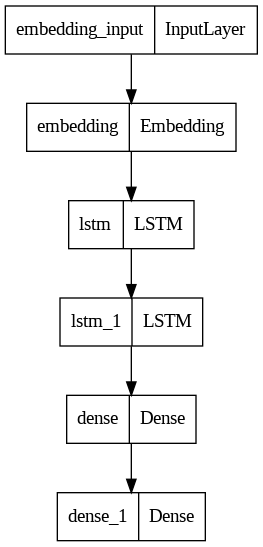

In [14]:
from tensorflow import keras
from keras.utils.vis_utils import plot_model

keras.utils.plot_model(model, to_file='model.png', show_layer_names=True)

### Callbacks:

In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard

checkpoint = ModelCheckpoint("nextword.h5", monitor='loss', verbose=1,
    save_best_only=True, mode='auto')

reduce = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=3, min_lr=0.0001, verbose = 1)

logdir='logsnextword1'
tensorboard_Visualization = TensorBoard(log_dir=logdir)

### Compile The Model:

In [17]:
model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])

### Fit The Model:

In [18]:
model.fit(X, y, epochs=5, batch_size=64, callbacks=[checkpoint, reduce, tensorboard_Visualization])

### Graph:

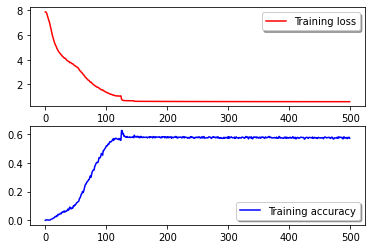

In [29]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2,1)
ax[0].plot(model.history.history['loss'], color='r', label="Training loss")
legend = ax[0].legend(loc='best', shadow=True)
ax[1].plot(model.history.history['accuracy'], color='b', label="Training accuracy")
legend = ax[1].legend(loc='best', shadow=True)


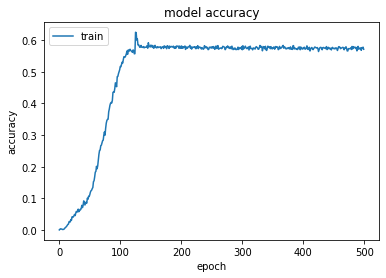

In [26]:
#epoch vs accuracy
plt.plot(model.history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

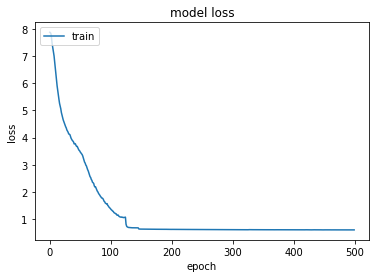

In [27]:
# epoch vs loss
plt.plot(model.history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

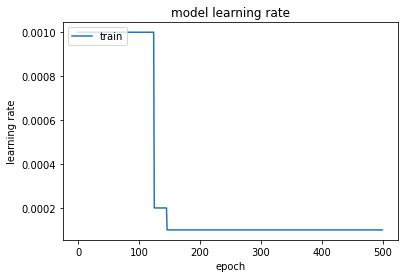

In [28]:
#epoch vs learning rate
plt.plot(model.history.history['lr'])
plt.title('model learning rate')
plt.ylabel('learning rate')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [31]:
from tensorflow.keras.models import load_model
model = load_model('nextword.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1, 10)             26170     
                                                                 
 lstm (LSTM)                 (None, 1, 1000)           4044000   
                                                                 
 lstm_1 (LSTM)               (None, 1000)              8004000   
                                                                 
 dense (Dense)               (None, 1000)              1001000   
                                                                 
 dense_1 (Dense)             (None, 2617)              2619617   
                                                                 
Total params: 15,694,787
Trainable params: 15,694,787
Non-trainable params: 0
_________________________________________________________________
